In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import TensorDataset, DataLoader
from pgvector.psycopg2 import register_vector

In [16]:
# model_name = "all-MiniLM-L6-v2"
# model = SentenceTransformer(f"sentence-transformers/{model_name}")
# embedding_size = model.get_sentence_embedding_dimension()
# embedding = model.encode(text, convert_to_numpy=True)

In [17]:
def low_rank_approximation(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

In [18]:
def low_rank_projection(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] * S[:k] 

In [19]:
def random_projection(latent: np.ndarray, k: int):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    R = np.random.randn(384, k) / np.sqrt(k)
    return latent @ R

In [20]:
def plot_proj_default(latent: np.ndarray, labels: np.ndarray):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    latent_2d = PCA(n_components=2).fit_transform(latent)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter( latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Label ID")
    plt.title("Plot 2d Random Projection")
    plt.show()

In [21]:
def plot_random_proj(latent: np.ndarray, k: int):
    latent_randp = random_projection(latent, k)
    latent_2d = PCA(n_components=2).fit_transform(latent_randp)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter( latent_2d[:, 0], latent_2d[:, 1], cmap="tab20", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Label ID")
    plt.title("Plot 2d Random Projection")
    plt.show()
    pass

In [22]:
def make_dataloader(X, y, batch_size=64):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
class ClassiNet(nn.Module):
    def __init__(self, input_dim, num_label=2):
        super(ClassiNet, self).__init__()
        self.classi = nn.Linear(input_dim, num_label)
    
    def forward(self, x):
        return self.classi(x)

epochs = 10

# One pass
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data, label in loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

In [ ]:
# Nested dim
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # data = random_projection()
    # data = low_rank_projection()
    # data = low_rank_approximation()

    print(f"\n[LOG] Running for {k = }")
    X_low = low_rank_projection(X, k)
    # X_low = random_projection(X, k)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

# plot_proj_default(X, y)
dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank projection")
plt.show()


[LOG] Running for k = 1
Epoch 5: Loss=0.5377 | Test Acc=78.40%
Epoch 10: Loss=0.4880 | Test Acc=78.30%

[LOG] Running for k = 2
Epoch 5: Loss=0.7830 | Test Acc=47.00%
Epoch 10: Loss=0.5190 | Test Acc=79.80%

[LOG] Running for k = 3
Epoch 5: Loss=0.3821 | Test Acc=87.50%
Epoch 10: Loss=0.3630 | Test Acc=88.40%

[LOG] Running for k = 4
Epoch 5: Loss=0.4825 | Test Acc=84.30%
Epoch 10: Loss=0.3956 | Test Acc=89.00%

[LOG] Running for k = 5
Epoch 5: Loss=0.5748 | Test Acc=84.50%
Epoch 10: Loss=0.4350 | Test Acc=87.90%

[LOG] Running for k = 6
Epoch 5: Loss=0.4227 | Test Acc=85.80%
Epoch 10: Loss=0.3719 | Test Acc=88.50%

[LOG] Running for k = 7
Epoch 5: Loss=0.5264 | Test Acc=85.20%
Epoch 10: Loss=0.4135 | Test Acc=88.50%

[LOG] Running for k = 8
Epoch 5: Loss=0.5471 | Test Acc=84.20%
Epoch 10: Loss=0.4184 | Test Acc=88.30%

[LOG] Running for k = 9
Epoch 5: Loss=0.3834 | Test Acc=87.50%
Epoch 10: Loss=0.3612 | Test Acc=88.00%

[LOG] Running for k = 10
Epoch 5: Loss=0.4648 | Test Acc=85.70%


[LOG] Running for k = 1
(5000, 1)
Epoch 5: Loss=0.6865 | Test Acc=53.80%
Epoch 10: Loss=0.6843 | Test Acc=54.60%

[LOG] Running for k = 2
(5000, 2)
Epoch 5: Loss=0.6987 | Test Acc=54.00%
Epoch 10: Loss=0.6923 | Test Acc=54.80%

[LOG] Running for k = 3
(5000, 3)
Epoch 5: Loss=0.7043 | Test Acc=50.30%
Epoch 10: Loss=0.6899 | Test Acc=55.30%

[LOG] Running for k = 4
(5000, 4)
Epoch 5: Loss=0.6891 | Test Acc=53.40%
Epoch 10: Loss=0.6868 | Test Acc=55.30%

[LOG] Running for k = 5
(5000, 5)
Epoch 5: Loss=0.6969 | Test Acc=52.30%
Epoch 10: Loss=0.6870 | Test Acc=55.40%

[LOG] Running for k = 6
(5000, 6)
Epoch 5: Loss=0.6944 | Test Acc=52.00%
Epoch 10: Loss=0.6863 | Test Acc=56.10%

[LOG] Running for k = 7
(5000, 7)
Epoch 5: Loss=0.6895 | Test Acc=54.80%
Epoch 10: Loss=0.6857 | Test Acc=54.70%

[LOG] Running for k = 8
(5000, 8)
Epoch 5: Loss=0.6796 | Test Acc=57.70%
Epoch 10: Loss=0.6757 | Test Acc=59.90%

[LOG] Running for k = 9
(5000, 9)
Epoch 5: Loss=0.6800 | Test Acc=58.00%
Epoch 10: Loss

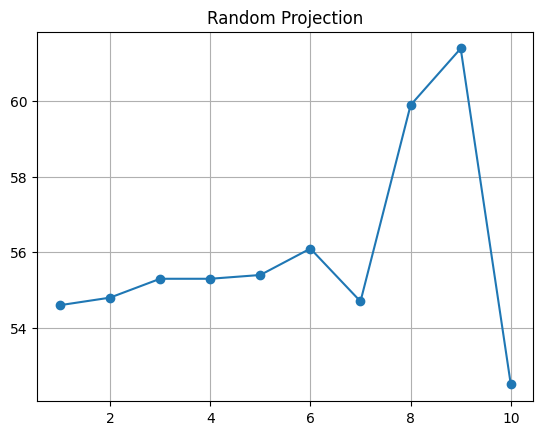

In [26]:
# Nested dim
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # data = random_projection()
    # data = low_rank_projection()
    # data = low_rank_approximation()

    print(f"\n[LOG] Running for {k = }")
    # X_low = low_rank_projection(X, k)
    X_low = random_projection(X, k)
    print(X_low.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.title("Random Projection")
plt.grid(True)
plt.show()



[LOG] Running for k = 1
(5000, 384)
Epoch 5: Loss=0.4626 | Test Acc=78.30%
Epoch 10: Loss=0.4608 | Test Acc=78.10%

[LOG] Running for k = 2
(5000, 384)
Epoch 5: Loss=0.3630 | Test Acc=88.50%
Epoch 10: Loss=0.3599 | Test Acc=88.70%

[LOG] Running for k = 3
(5000, 384)
Epoch 5: Loss=0.3669 | Test Acc=88.40%
Epoch 10: Loss=0.3599 | Test Acc=88.70%

[LOG] Running for k = 4
(5000, 384)
Epoch 5: Loss=0.3694 | Test Acc=88.20%
Epoch 10: Loss=0.3617 | Test Acc=88.60%

[LOG] Running for k = 5
(5000, 384)
Epoch 5: Loss=0.3694 | Test Acc=88.30%
Epoch 10: Loss=0.3607 | Test Acc=88.40%

[LOG] Running for k = 6
(5000, 384)
Epoch 5: Loss=0.3721 | Test Acc=88.40%
Epoch 10: Loss=0.3630 | Test Acc=88.70%

[LOG] Running for k = 7
(5000, 384)
Epoch 5: Loss=0.3734 | Test Acc=88.70%
Epoch 10: Loss=0.3592 | Test Acc=88.40%

[LOG] Running for k = 8
(5000, 384)
Epoch 5: Loss=0.3684 | Test Acc=88.50%
Epoch 10: Loss=0.3588 | Test Acc=88.10%

[LOG] Running for k = 9
(5000, 384)
Epoch 5: Loss=0.3705 | Test Acc=88.

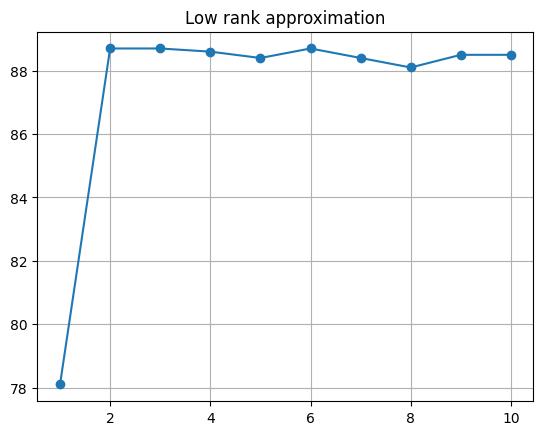

In [27]:
# Nested dim
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\n[LOG] Running for {k = }")
    # X_low = low_rank_projection(X, k)
    # X_low = random_projection(X, k)
    X_low = low_rank_approximation(X, k)
    print(X_low.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ClassiNet(384).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank approximation")
plt.show()



[LOG] Running for k = 384
Epoch 5: Loss=0.4070 | Test Acc=83.60%
Epoch 10: Loss=0.3403 | Test Acc=85.60%


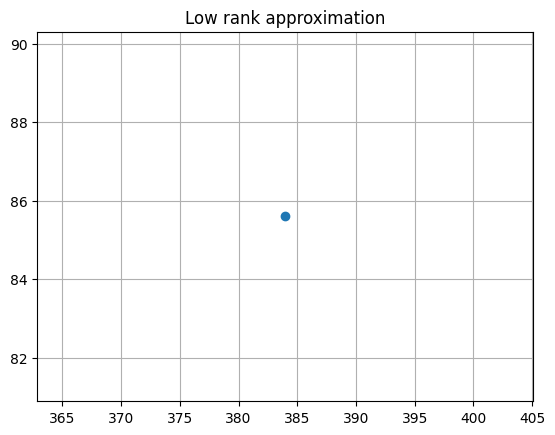

In [29]:
# Nested dim
K = [384]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\n[LOG] Running for {k = }")
    # X_low = low_rank_projection(X, k)
    # X_low = random_projection(X, k)
    # X_low = low_rank_approximation(X, k)
    # print(X_low.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ClassiNet(384).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank approximation")
plt.show()
